[Glove embeddings](https://nlp.stanford.edu/projects/glove/) file required: "glove.6B.300d.txt".

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import numpy as np
import time
import random
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from tqdm.notebook import tqdm
from seqeval.metrics import accuracy_score
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dataset = "predfull" #"asp" "predfull"

In [3]:
if dataset == "asp":
    CONLL_DATA = "sequence_labelling_aspect/"
else:
    CONLL_DATA = "sequence_labelling_predicate/"

In [4]:
"""input/output data wrapper for CoNNL file format used in  NER-2003 Shared Task dataset"""
import codecs

def get_words_num(word_sequences):
    return sum(len(word_seq) for word_seq in word_sequences)


class DataIOConnlNer2003():
    """DataIONerConnl2003 is an input/output data wrapper for CoNNL-2003 Shared Task file format.
    Tjong Kim Sang, Erik F., and Fien De Meulder. "Introduction to the CoNLL-2003 shared task: Language-independent
    named entity recognition." Proceedings of the seventh conference on Natural language learning at HLT-NAACL
    2003-Volume 4. Association for Computational Linguistics, 2003.
    """
    def read_train_dev_test(self, train, dev, test):
        word_sequences_train, tag_sequences_train = self.read_data(fn=train)
        word_sequences_dev, tag_sequences_dev = self.read_data(fn=dev)
        word_sequences_test, tag_sequences_test = self.read_data(fn=test)
        return word_sequences_train, tag_sequences_train, word_sequences_dev, tag_sequences_dev, word_sequences_test, \
               tag_sequences_test

    def read_data(self, fn, verbose=True, column_no=-1):
        word_sequences = list()
        tag_sequences = list()
        with codecs.open(fn, 'r', 'utf-8') as f:
            lines = f.readlines()
        curr_words = list()
        curr_tags = list()
        for k in range(len(lines)):
            line = lines[k].strip()
            if len(line) == 0 or line.startswith('-DOCSTART-'): # new sentence or new document
                if len(curr_words) > 0:
                    word_sequences.append(curr_words)
                    tag_sequences.append(curr_tags)
                    curr_words = list()
                    curr_tags = list()
                continue
            strings = line.split('\t')
            word = strings[0]
            tag = strings[column_no] # be default, we take the last tag
            curr_words.append(word)
            curr_tags.append(tag)
            if k == len(lines) - 1:
                word_sequences.append(curr_words)
                tag_sequences.append(curr_tags)
        if verbose:
            print('Loading from %s: %d samples, %d words.' % (fn, len(word_sequences), get_words_num(word_sequences)))
        return word_sequences, tag_sequences

In [5]:
io = DataIOConnlNer2003()

In [6]:
if dataset == "asp":
    train_words, train_labels, dev_words, dev_labels, test_words, test_labels = \
    io.read_train_dev_test(CONLL_DATA + "train_aspect.tsv",
                           CONLL_DATA + "dev_aspect.tsv",
                           CONLL_DATA + "test_aspect.tsv")
else:
    train_words, train_labels, dev_words, dev_labels, test_words, test_labels = \
    io.read_train_dev_test(CONLL_DATA + "train_pred_full.tsv",
                           CONLL_DATA + "dev_pred_full.tsv",
                           CONLL_DATA + "test_pred_full.tsv")

Loading from sequence_labelling_predicate/train_pred_full.tsv: 3077 samples, 89350 words.
Loading from sequence_labelling_predicate/dev_pred_full.tsv: 402 samples, 12360 words.
Loading from sequence_labelling_predicate/test_pred_full.tsv: 488 samples, 13736 words.


In [7]:
tag2ix = {
    '<pad>': 0,
    'O': 1,
    'B-OBJ': 2,
    'I-OBJ': 3
}
if dataset == "asp":
    tag2ix['B-ASPECT'] = 4
    tag2ix['I-ASPECT'] = 5
else:
    tag2ix['B-PREDFULL'] = 4
    tag2ix['I-PREDFULL'] = 5

ix2tag = {value: key for key, value in tag2ix.items()}

In [8]:
conll_train = list(zip(train_words, train_labels))
conll_dev = list(zip(dev_words, dev_labels))
conll_test = list(zip(test_words, test_labels))

In [9]:
# load the embeddings
def load_embeddings(emb_path):
    clf_embeddings = {}
    emb_vocab = set()
    for line in open(emb_path):
        line = line.strip('\n').split()
        word, emb = line[0], line[1:]
        emb = [float(e) for e in emb]
        clf_embeddings[word] = emb
    for w in clf_embeddings:
        emb_vocab.add(w)
    word2idx = {w: idx for (idx, w) in enumerate(emb_vocab)}
    max_val = max(word2idx.values())
    
    word2idx['UNK'] = max_val + 1
    word2idx['<pad>'] = max_val + 2
    emb_dim = len(list(clf_embeddings.values())[0])
    clf_embeddings['UNK'] = [0.0 for i in range(emb_dim)]
    clf_embeddings['<pad>'] = [0.0 for i in range(emb_dim)]
    
    embeddings = [[] for i in range(len(word2idx))]
    for w in word2idx:
        embeddings[word2idx[w]] = clf_embeddings[w]
    embeddings = torch.Tensor(embeddings)
    return embeddings, word2idx
embeddings, vocab = load_embeddings('glove.6B.300d.txt')

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
def make_tensors(batch):
    tokens, labels = tuple(zip(*batch))
    pad = vocab['<pad>']
    pad_label = tag2ix['<pad>']
    lines_ix = []
    tags_ix = []
    seq_lens = []
    for i in range(len(tokens)):
        line_ix = [vocab.get(l, vocab['UNK']) for l in tokens[i]]
        lines_ix.append(torch.LongTensor(line_ix))
        tag_ix = [tag2ix[l] for l in labels[i]]
        tags_ix.append(torch.LongTensor(tag_ix))
        seq_lens.append(len(line_ix))
    tensor_x = pad_sequence(lines_ix, batch_first=True, padding_value=pad)
    tensor_y = pad_sequence(tags_ix, batch_first=True, padding_value=pad_label)
    return tensor_x, tensor_y, seq_lens

In [12]:
def make_tensors_predict(batch):
    tokens = batch
    pad = vocab['<pad>']
    lines_ix = []
    seq_lens = []
    for i in range(len(tokens)):
        line_ix = [vocab.get(l, vocab['UNK']) for l in tokens[i]]
        lines_ix.append(torch.LongTensor(line_ix))
        seq_lens.append(len(line_ix))
    tensor_x = pad_sequence(lines_ix, batch_first=True, padding_value=pad)
    return tensor_x, seq_lens

In [13]:
def log_sum_exp(x):
    max_score, _ = torch.max(x, -1)
    max_score_broadcast = max_score.unsqueeze(-1).expand_as(x)
    return max_score + torch.log(torch.sum(torch.exp(x - max_score_broadcast), -1))

In [14]:
class CRF(nn.Module):
    def __init__(self, states_num, pad_idx, start_idx, device):
        super(CRF, self).__init__()
        self.states_num = states_num
        self.pad_idx = pad_idx
        self.start_idx = start_idx
        # Transition matrix contains log probabilities from state j to state i
        self.transition_matrix = nn.Parameter(torch.zeros(states_num, states_num, dtype=torch.float))
        nn.init.normal_(self.transition_matrix, -1, 0.1)
        # Default initialization
        self.transition_matrix.data[self.start_idx, :] = -9999.0
        self.transition_matrix.data[:, self.pad_idx] = -9999.0
        self.transition_matrix.data[self.pad_idx, :] = -9999.0
        self.transition_matrix.data[self.pad_idx, self.pad_idx] = 0.0

    def get_empirical_transition_matrix(self, tag_sequences_train, tag2ix):

        empirical_transition_matrix = torch.zeros(self.states_num, self.states_num, dtype=torch.long)
        for tag_seq in tag_sequences_train:
            s = tag2ix[tag_seq[0]]
            empirical_transition_matrix[s, self.start_idx] += 1
            for n, tag in enumerate(tag_seq):
                if n + 1 >= len(tag_seq):
                    break
                next_tag = tag_seq[n + 1]
                j = tag2ix[tag]
                i = tag2ix[next_tag]
                empirical_transition_matrix[i, j] += 1
        return empirical_transition_matrix

    def init_transition_matrix_empirical(self, tag_sequences_train, tag2ix):
        print('Initializing transition matrix.')
        # Calculate statistics for tag transitions
        empirical_transition_matrix = self.get_empirical_transition_matrix(tag_sequences_train, tag2ix)
        # Initialize
        for i in range(len(tag2ix)):
            for j in range(len(tag2ix)):
                if empirical_transition_matrix[i, j] == 0:
                    self.transition_matrix.data[i, j] = -9999.0
                #self.transition_matrix.data[i, j] = torch.log(empirical_transition_matrix[i, j].float() + 10**-32)
        print('Initialized transition matrix.')

    def numerator(self, features_rnn_compressed, states_tensor, mask_tensor, device):
        # features_input_tensor: batch_num x max_seq_len x states_num
        # states_tensor: batch_num x max_seq_len
        # mask_tensor: batch_num x max_seq_len
        batch_num, max_seq_len = states_tensor.shape
        score = torch.zeros(batch_num, dtype=torch.float).to(device)
        start_states_tensor = torch.zeros(batch_num, 1, dtype=torch.long).fill_(self.start_idx).to(device)
        states_tensor = torch.cat([start_states_tensor, states_tensor], 1)
        for n in range(max_seq_len):
            curr_mask = mask_tensor[:, n]
            curr_emission = torch.zeros(batch_num, dtype=torch.float).to(device)
            curr_transition = torch.zeros(batch_num, dtype=torch.float).to(device)
            for k in range(batch_num):
                curr_emission[k] = features_rnn_compressed[k, n, states_tensor[k, n + 1]].unsqueeze(0)
                curr_states_seq = states_tensor[k]
                # !!!
                curr_transition[k] = self.transition_matrix[curr_states_seq[n + 1], curr_states_seq[n]].unsqueeze(0)
            score = score + curr_emission*curr_mask + curr_transition*curr_mask
        return score

    def denominator(self, features_rnn_compressed, mask_tensor, device):
        # features_rnn_compressed: batch x max_seq_len x states_num
        # mask_tensor: batch_num x max_seq_len
        batch_num, max_seq_len = mask_tensor.shape
        score = torch.zeros(batch_num, self.states_num, dtype=torch.float).fill_(-9999.0).to(device)
        score[:, self.start_idx] = 0.
        for n in range(max_seq_len):
            curr_mask = mask_tensor[:, n].unsqueeze(-1).expand_as(score)
            curr_score = score.unsqueeze(1).expand(-1, *self.transition_matrix.size())
            curr_emission = features_rnn_compressed[:, n].unsqueeze(-1).expand_as(curr_score)
            curr_transition = self.transition_matrix.unsqueeze(0).expand_as(curr_score)
            #curr_score = torch.logsumexp(curr_score + curr_emission + curr_transition, dim=2)
            curr_score = log_sum_exp(curr_score + curr_emission + curr_transition)
            score = curr_score * curr_mask + score * (1 - curr_mask)
        #score = torch.logsumexp(score, dim=1)
        score = log_sum_exp(score)
        return score

    def decode_viterbi(self, features_rnn_compressed, mask_tensor, device):
        # features_rnn_compressed: batch x max_seq_len x states_num
        # mask_tensor: batch_num x max_seq_len
        batch_size, max_seq_len = mask_tensor.shape
        seq_len_list = [int(mask_tensor[k].sum().item()) for k in range(batch_size)]
        # Step 1. Calculate scores & backpointers
        score = torch.Tensor(batch_size, self.states_num).fill_(-9999.).to(device)
        score[:, self.start_idx] = 0.0
        backpointers = torch.LongTensor(batch_size, max_seq_len, self.states_num).to(device)
        for n in range(max_seq_len):
            curr_emissions = features_rnn_compressed[:, n]
            curr_score = torch.Tensor(batch_size, self.states_num).to(device)
            curr_backpointers = torch.LongTensor(batch_size, self.states_num).to(device)
            for curr_state in range(self.states_num):
                T = self.transition_matrix[curr_state, :].unsqueeze(0).expand(batch_size, self.states_num)
                max_values, max_indices = torch.max(score + T, 1)
                curr_score[:, curr_state] = max_values
                curr_backpointers[:, curr_state] = max_indices
            curr_mask = mask_tensor[:, n].unsqueeze(1).expand(batch_size, self.states_num)
            score = score * (1 - curr_mask) + (curr_score + curr_emissions) * curr_mask
            backpointers[:, n, :] = curr_backpointers # shape: batch_size x max_seq_len x state_num
        best_score_batch, last_best_state_batch = torch.max(score, 1)
        # Step 2. Find the best path
        best_path_batch = [[state] for state in last_best_state_batch.tolist()]
        for k in range(batch_size):
            curr_best_state = last_best_state_batch[k]
            curr_seq_len = seq_len_list[k]
            for n in reversed(range(1, curr_seq_len)):
                curr_best_state = backpointers[k, n, curr_best_state].item()
                best_path_batch[k].insert(0, curr_best_state)
        return best_path_batch

In [15]:
class LSTMCRFTagger(nn.Module):

    def __init__(self, embeddings, hidden_dim, tagset_size, lstm_layer=1, dropout_ratio=0.5):
        super(LSTMCRFTagger, self).__init__()
        self.hidden_dim = hidden_dim
        
        # load pre-trained embeddings
        self.embedding = nn.Embedding.from_pretrained(embeddings)
        # embeddings are not fine-tuned
        self.embedding.weight.requires_grad = False
        
        self.dropout = torch.nn.Dropout(p=dropout_ratio)
        
        # RNN layer with LSTM cells
        self.lstm = nn.LSTM(input_size=self.embedding.embedding_dim,
                            hidden_size=hidden_dim,
                            num_layers=lstm_layer, 
                            bidirectional=True,
                            batch_first=True)
        
        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(2 * hidden_dim, tagset_size + 1)
        
        self.crf = CRF(tagset_size + 1, 0, tagset_size, device)

    def forward_birnn(self, sents, seq_lens, device):
        
        _, max_seq_len = sents.shape

        embeds = self.embedding(sents)
        
        embeds_d = self.dropout(embeds)
        
        embeds_packed, reverse_sort_index = self.pack(embeds_d, seq_lens, device)
        
        lstm_out_packed, _ = self.lstm(embeds_packed)
        
        lstm_out_unpacked = self.unpack(lstm_out_packed, max_seq_len, reverse_sort_index)
        
        lstm_out_unpacked_d = self.dropout(lstm_out_unpacked)

        tag_space = self.hidden2tag(lstm_out_unpacked_d)

        return tag_space
    
    def get_mask_from_lens(self, seq_lens, device):
        batch_num = len(seq_lens)
        max_seq_len = max(seq_lens)
        mask_tensor = torch.zeros(batch_num, max_seq_len, dtype=torch.float).to(device)
        for k, seq_len in enumerate(seq_lens):
            mask_tensor[k, :seq_len] = 1
        return mask_tensor
    
    def viterbi_loss(self, features_rnn, seq_lens, tags_batch, device):
        
        mask = self.get_mask_from_lens(seq_lens, device)  # batch_num x max_seq_len
        
        numerator = self.crf.numerator(features_rnn, tags_batch, mask, device)
        
        denominator = self.crf.denominator(features_rnn, mask, device)
        
        loss = -torch.mean(numerator - denominator)
        
        return loss
    
    def sort_by_seq_len_list(self, seq_len_list, device):
        data_num = len(seq_len_list)
        sort_indices = sorted(range(len(seq_len_list)), key=seq_len_list.__getitem__, reverse=True)
        reverse_sort_indices = [-1 for _ in range(data_num)]
        for i in range(data_num):
            reverse_sort_indices[sort_indices[i]] = i
        sort_index = torch.tensor(sort_indices, dtype=torch.long).to(device)
        reverse_sort_index = torch.tensor(reverse_sort_indices, dtype=torch.long).to(device)
        return sorted(seq_len_list, reverse=True), sort_index, reverse_sort_index
    
    def pack(self, input_tensor, seq_len_list, device):
        sorted_seq_len_list, sort_index, reverse_sort_index = self.sort_by_seq_len_list(seq_len_list, device)
        input_tensor_sorted = torch.index_select(input_tensor, dim=0, index=sort_index)
        return pack_padded_sequence(input_tensor_sorted, lengths=sorted_seq_len_list, batch_first=True), \
               reverse_sort_index

    def unpack(self, output_packed, max_seq_len, reverse_sort_index):
        output_tensor_sorted, _ = pad_packed_sequence(output_packed, batch_first=True, total_length=max_seq_len)
        output_tensor = torch.index_select(output_tensor_sorted, dim=0, index=reverse_sort_index)
        return output_tensor

In [16]:
def train_model_epoch(train_dataset, model, optimizer, bs):
    model.train()
    train_loss = 0
    train_acc = 0
    data = DataLoader(train_dataset, batch_size=bs, 
                      shuffle=True,
                      collate_fn=make_tensors,
                      num_workers=0)
    
    for batch in tqdm(data):
        features, labels, seq_lens = batch
        
        labels = labels.to(device)
        features = features.to(device)
        
        optimizer.zero_grad()
        features_rnn = model.forward_birnn(features, seq_lens, device)
        loss = model.viterbi_loss(features_rnn, seq_lens, labels, device)
        loss.backward()
        optimizer.step()
        
        
        train_loss += loss.item()

    return train_loss * bs / len(train_dataset)


def train(train_dataset, test_dataset, model, optimizer, n_epochs, bs, pred_bs):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    print('Training...')
    for epoch in range(n_epochs):
        print('-' * 50)
        print('EPOCH ' + str(epoch))
        train_loss = train_model_epoch(train_dataset, model, optimizer, bs=bs)
        print(f'Train loss {train_loss:.6f}')
        print('Evaluating...')
        train_loss, train_acc = test(train_dataset, model, batch_size=pred_bs, device=device)
        test_loss, test_acc = test(test_dataset, model, batch_size=pred_bs, device=device)
        print(f'Train loss {train_loss:.6f}')
        print(f'Train accuracy: {train_acc: .6f}')
        print(f'Test loss: {test_loss:.6f}')
        print(f'Test accuracy: {test_acc: .6f}')
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(test_loss)
        val_accs.append(test_acc)
    print('Finished training.')
    return train_losses, train_accs, val_losses, val_accs


def test(test_dataset, model, batch_size, device=None):
    model.eval()
    loss = 0
    acc = 0
    preds = []
    labs = []
    data_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=make_tensors)
    for sample in tqdm(data_loader):
        features, labels, seq_lens = sample
        if device is not None:
            labels = labels.to(device)
            features = features.to(device)
        with torch.no_grad():
            features_rnn = model.forward_birnn(features, seq_lens, device)
            loss += model.viterbi_loss(features_rnn, seq_lens, labels, device)
            mask = model.get_mask_from_lens(seq_lens, device)
            y_pred = model.crf.decode_viterbi(features_rnn, mask, device)
            y_true = labels
#             y_pred = y_pred.tolist()
            y_true = y_true.tolist()
            for i, sent_len in enumerate(seq_lens):
                y_pred[i] = y_pred[i][:sent_len]
                y_true[i] = y_true[i][:sent_len]
            preds += y_pred
            labs += y_true
    
    acc = accuracy_score(labs, preds)
    
    return loss * batch_size / len(test_dataset), acc

def predict(input_dataset, model, batch_size, device=None):
    preds = []
    model.eval()
    data_loader = DataLoader(input_dataset, batch_size=batch_size, collate_fn=make_tensors_predict)
    for sample in tqdm(data_loader):
        features, seq_lens = sample
        if device is not None:
            features = features.to(device)
        with torch.no_grad():
            features_rnn = model.forward_birnn(features, seq_lens, device)
            
            mask = model.get_mask_from_lens(seq_lens, device)
            y_pred = model.crf.decode_viterbi(features_rnn, mask, device)
#             y_pred = y_pred.tolist()
            for i, sent_len in enumerate(seq_lens):
                y_pred[i] = y_pred[i][:sent_len]
            y_pred = [[ix2tag[w] for w in sent] for sent in y_pred]
            preds += y_pred
    
    return preds

In [17]:
N_EPOCHS = 100
BATCH_SIZE = 24
LEARNING_RATE = 1e-5
ALPHA = 0
hidden_dim = 128
layers = 1
PRED_BATCH_SIZE = 100

model = LSTMCRFTagger(embeddings, hidden_dim, len(tag2ix), lstm_layer=layers)
model.crf.init_transition_matrix_empirical(train_labels, tag2ix)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=ALPHA)

model = model.to(device)

train_data = conll_train.copy()


train_losses, train_accs, val_losses, val_accs = train(train_data, conll_dev, 
                                                       model, optimizer, 
                                                       n_epochs=N_EPOCHS, 
                                                       bs=BATCH_SIZE, 
                                                       pred_bs=PRED_BATCH_SIZE)

Initializing transition matrix.
Initialized transition matrix.
Training...
--------------------------------------------------
EPOCH 0



Train loss 32.165801
Evaluating...



Train loss 29.887289
Train accuracy:  0.497661
Test loss: 39.782249
Test accuracy:  0.490453
--------------------------------------------------
EPOCH 1



Train loss 28.171210
Evaluating...



Train loss 25.170534
Train accuracy:  0.887040
Test loss: 33.578026
Test accuracy:  0.877751
--------------------------------------------------
EPOCH 2



Train loss 23.321464
Evaluating...



Train loss 19.048103
Train accuracy:  0.905193
Test loss: 25.512697
Test accuracy:  0.895793
--------------------------------------------------
EPOCH 3



Train loss 17.149481
Evaluating...



Train loss 12.443816
Train accuracy:  0.906391
Test loss: 16.799755
Test accuracy:  0.897168
--------------------------------------------------
EPOCH 4



Train loss 11.860704
Evaluating...



Train loss 10.238934
Train accuracy:  0.906413
Test loss: 14.008706
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 5



Train loss 10.238696
Evaluating...



Train loss 10.019208
Train accuracy:  0.906424
Test loss: 13.862579
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 6



Train loss 9.797512
Evaluating...



Train loss 9.746760
Train accuracy:  0.906424
Test loss: 13.620253
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 7



Train loss 9.496898
Evaluating...



Train loss 9.458925
Train accuracy:  0.906424
Test loss: 13.350428
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 8



Train loss 9.276233
Evaluating...



Train loss 9.193924
Train accuracy:  0.906424
Test loss: 13.112252
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 9



Train loss 9.026699
Evaluating...



Train loss 8.967771
Train accuracy:  0.906424
Test loss: 12.924690
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 10



Train loss 8.814217
Evaluating...



Train loss 8.741034
Train accuracy:  0.906424
Test loss: 12.735471
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 11



Train loss 8.601928
Evaluating...



Train loss 8.527168
Train accuracy:  0.906424
Test loss: 12.567080
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 12



Train loss 8.430384
Evaluating...



Train loss 8.320076
Train accuracy:  0.906447
Test loss: 12.402122
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 13



Train loss 8.236846
Evaluating...



Train loss 8.115100
Train accuracy:  0.906491
Test loss: 12.244123
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 14



Train loss 8.031679
Evaluating...



Train loss 7.891119
Train accuracy:  0.906536
Test loss: 12.047596
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 15



Train loss 7.830626
Evaluating...



Train loss 7.681377
Train accuracy:  0.906849
Test loss: 11.878376
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 16



Train loss 7.615385
Evaluating...



Train loss 7.468977
Train accuracy:  0.907443
Test loss: 11.702836
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 17



Train loss 7.407000
Evaluating...



Train loss 7.236479
Train accuracy:  0.908193
Test loss: 11.489424
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 18



Train loss 7.229109
Evaluating...



Train loss 7.029310
Train accuracy:  0.909121
Test loss: 11.325090
Test accuracy:  0.897330
--------------------------------------------------
EPOCH 19



Train loss 7.057170
Evaluating...



Train loss 6.810513
Train accuracy:  0.910263
Test loss: 11.139490
Test accuracy:  0.897411
--------------------------------------------------
EPOCH 20



Train loss 6.840001
Evaluating...



Train loss 6.612798
Train accuracy:  0.911707
Test loss: 10.997857
Test accuracy:  0.897492
--------------------------------------------------
EPOCH 21



Train loss 6.662067
Evaluating...



Train loss 6.391097
Train accuracy:  0.913777
Test loss: 10.797359
Test accuracy:  0.897573
--------------------------------------------------
EPOCH 22



Train loss 6.477226
Evaluating...



Train loss 6.184500
Train accuracy:  0.915993
Test loss: 10.633454
Test accuracy:  0.898948
--------------------------------------------------
EPOCH 23



Train loss 6.292312
Evaluating...



Train loss 5.988490
Train accuracy:  0.917806
Test loss: 10.488094
Test accuracy:  0.900081
--------------------------------------------------
EPOCH 24



Train loss 6.143617
Evaluating...



Train loss 5.786850
Train accuracy:  0.920336
Test loss: 10.323928
Test accuracy:  0.900890
--------------------------------------------------
EPOCH 25



Train loss 5.926491
Evaluating...



Train loss 5.589008
Train accuracy:  0.923223
Test loss: 10.158376
Test accuracy:  0.902023
--------------------------------------------------
EPOCH 26



Train loss 5.765102
Evaluating...



Train loss 5.423433
Train accuracy:  0.924745
Test loss: 10.078326
Test accuracy:  0.902346
--------------------------------------------------
EPOCH 27



Train loss 5.616951
Evaluating...



Train loss 5.235473
Train accuracy:  0.928047
Test loss: 9.921064
Test accuracy:  0.902832
--------------------------------------------------
EPOCH 28



Train loss 5.451200
Evaluating...



Train loss 5.077430
Train accuracy:  0.929972
Test loss: 9.842691
Test accuracy:  0.903398
--------------------------------------------------
EPOCH 29



Train loss 5.312729
Evaluating...



Train loss 4.906255
Train accuracy:  0.932613
Test loss: 9.711766
Test accuracy:  0.903722
--------------------------------------------------
EPOCH 30



Train loss 5.158982
Evaluating...



Train loss 4.743711
Train accuracy:  0.935490
Test loss: 9.597818
Test accuracy:  0.904612
--------------------------------------------------
EPOCH 31



Train loss 5.050660
Evaluating...



Train loss 4.587509
Train accuracy:  0.938265
Test loss: 9.490378
Test accuracy:  0.905502
--------------------------------------------------
EPOCH 32



Train loss 4.905421
Evaluating...



Train loss 4.454236
Train accuracy:  0.940347
Test loss: 9.439822
Test accuracy:  0.905744
--------------------------------------------------
EPOCH 33



Train loss 4.776395
Evaluating...



Train loss 4.329657
Train accuracy:  0.941914
Test loss: 9.407716
Test accuracy:  0.906149
--------------------------------------------------
EPOCH 34



Train loss 4.652574
Evaluating...



Train loss 4.189987
Train accuracy:  0.944275
Test loss: 9.305905
Test accuracy:  0.906634
--------------------------------------------------
EPOCH 35



Train loss 4.531012
Evaluating...



Train loss 4.047782
Train accuracy:  0.946872
Test loss: 9.158188
Test accuracy:  0.907362
--------------------------------------------------
EPOCH 36



Train loss 4.459664
Evaluating...



Train loss 3.940714
Train accuracy:  0.948103
Test loss: 9.138454
Test accuracy:  0.908172
--------------------------------------------------
EPOCH 37



Train loss 4.345032
Evaluating...



Train loss 3.827299
Train accuracy:  0.949591
Test loss: 9.070310
Test accuracy:  0.908900
--------------------------------------------------
EPOCH 38



Train loss 4.224612
Evaluating...



Train loss 3.730263
Train accuracy:  0.950565
Test loss: 9.042968
Test accuracy:  0.909547
--------------------------------------------------
EPOCH 39



Train loss 4.170079
Evaluating...



Train loss 3.636586
Train accuracy:  0.951461
Test loss: 9.015162
Test accuracy:  0.909871
--------------------------------------------------
EPOCH 40



Train loss 4.074158
Evaluating...



Train loss 3.535326
Train accuracy:  0.952893
Test loss: 8.922394
Test accuracy:  0.910275
--------------------------------------------------
EPOCH 41



Train loss 3.994518
Evaluating...



Train loss 3.454468
Train accuracy:  0.953956
Test loss: 8.909195
Test accuracy:  0.910841
--------------------------------------------------
EPOCH 42



Train loss 3.936694
Evaluating...



Train loss 3.380991
Train accuracy:  0.954684
Test loss: 8.904121
Test accuracy:  0.911084
--------------------------------------------------
EPOCH 43



Train loss 3.860293
Evaluating...



Train loss 3.317648
Train accuracy:  0.955367
Test loss: 8.939866
Test accuracy:  0.911165
--------------------------------------------------
EPOCH 44



Train loss 3.809070
Evaluating...



Train loss 3.240078
Train accuracy:  0.956396
Test loss: 8.883719
Test accuracy:  0.911489
--------------------------------------------------
EPOCH 45



Train loss 3.704302
Evaluating...



Train loss 3.174477
Train accuracy:  0.957247
Test loss: 8.863152
Test accuracy:  0.911893
--------------------------------------------------
EPOCH 46



Train loss 3.669234
Evaluating...



Train loss 3.115461
Train accuracy:  0.958019
Test loss: 8.854628
Test accuracy:  0.912783
--------------------------------------------------
EPOCH 47



Train loss 3.593766
Evaluating...



Train loss 3.048768
Train accuracy:  0.959161
Test loss: 8.772025
Test accuracy:  0.913673
--------------------------------------------------
EPOCH 48



Train loss 3.600870
Evaluating...



Train loss 3.001603
Train accuracy:  0.959631
Test loss: 8.817036
Test accuracy:  0.913997
--------------------------------------------------
EPOCH 49



Train loss 3.516645
Evaluating...



Train loss 2.948960
Train accuracy:  0.960246
Test loss: 8.789207
Test accuracy:  0.914563
--------------------------------------------------
EPOCH 50



Train loss 3.487149
Evaluating...



Train loss 2.914310
Train accuracy:  0.960403
Test loss: 8.856096
Test accuracy:  0.914725
--------------------------------------------------
EPOCH 51



Train loss 3.415999
Evaluating...



Train loss 2.859903
Train accuracy:  0.961153
Test loss: 8.781487
Test accuracy:  0.915210
--------------------------------------------------
EPOCH 52



Train loss 3.410695
Evaluating...



Train loss 2.813777
Train accuracy:  0.961970
Test loss: 8.757722
Test accuracy:  0.915696
--------------------------------------------------
EPOCH 53



Train loss 3.391841
Evaluating...



Train loss 2.785728
Train accuracy:  0.962059
Test loss: 8.833288
Test accuracy:  0.915615
--------------------------------------------------
EPOCH 54



Train loss 3.341833
Evaluating...



Train loss 2.745045
Train accuracy:  0.962708
Test loss: 8.828313
Test accuracy:  0.915696
--------------------------------------------------
EPOCH 55



Train loss 3.335564
Evaluating...



Train loss 2.696940
Train accuracy:  0.963660
Test loss: 8.723979
Test accuracy:  0.916667
--------------------------------------------------
EPOCH 56



Train loss 3.294213
Evaluating...



Train loss 2.673648
Train accuracy:  0.963772
Test loss: 8.814877
Test accuracy:  0.916262
--------------------------------------------------
EPOCH 57



Train loss 3.227966
Evaluating...



Train loss 2.639807
Train accuracy:  0.964141
Test loss: 8.804626
Test accuracy:  0.916424
--------------------------------------------------
EPOCH 58



Train loss 3.205328
Evaluating...



Train loss 2.610326
Train accuracy:  0.964331
Test loss: 8.822520
Test accuracy:  0.916343
--------------------------------------------------
EPOCH 59



Train loss 3.195407
Evaluating...



Train loss 2.571223
Train accuracy:  0.964880
Test loss: 8.730373
Test accuracy:  0.916909
--------------------------------------------------
EPOCH 60



Train loss 3.170296
Evaluating...



Train loss 2.555728
Train accuracy:  0.964734
Test loss: 8.849591
Test accuracy:  0.916505
--------------------------------------------------
EPOCH 61



Train loss 3.111356
Evaluating...



Train loss 2.546719
Train accuracy:  0.964701
Test loss: 9.006761
Test accuracy:  0.916262
--------------------------------------------------
EPOCH 62



Train loss 3.133633
Evaluating...



Train loss 2.501674
Train accuracy:  0.965339
Test loss: 8.873954
Test accuracy:  0.916990
--------------------------------------------------
EPOCH 63



Train loss 3.066212
Evaluating...



Train loss 2.467504
Train accuracy:  0.965820
Test loss: 8.807517
Test accuracy:  0.917799
--------------------------------------------------
EPOCH 64



Train loss 3.071181
Evaluating...



Train loss 2.456091
Train accuracy:  0.965663
Test loss: 8.926916
Test accuracy:  0.917233
--------------------------------------------------
EPOCH 65



Train loss 3.057601
Evaluating...



Train loss 2.431607
Train accuracy:  0.965932
Test loss: 8.931641
Test accuracy:  0.917718
--------------------------------------------------
EPOCH 66



Train loss 3.038965
Evaluating...



Train loss 2.408540
Train accuracy:  0.966066
Test loss: 8.935871
Test accuracy:  0.917880
--------------------------------------------------
EPOCH 67



Train loss 3.013545
Evaluating...



Train loss 2.381410
Train accuracy:  0.966603
Test loss: 8.892902
Test accuracy:  0.918123
--------------------------------------------------
EPOCH 68



Train loss 2.973914
Evaluating...



Train loss 2.355997
Train accuracy:  0.967264
Test loss: 8.844420
Test accuracy:  0.918770
--------------------------------------------------
EPOCH 69



Train loss 2.958224
Evaluating...



Train loss 2.348346
Train accuracy:  0.966805
Test loss: 8.998057
Test accuracy:  0.917880
--------------------------------------------------
EPOCH 70



Train loss 2.940508
Evaluating...



Train loss 2.326139
Train accuracy:  0.967252
Test loss: 8.973909
Test accuracy:  0.917961
--------------------------------------------------
EPOCH 71



Train loss 2.918985
Evaluating...



Train loss 2.296705
Train accuracy:  0.967756
Test loss: 8.908976
Test accuracy:  0.918285
--------------------------------------------------
EPOCH 72



Train loss 2.889120
Evaluating...



Train loss 2.265725
Train accuracy:  0.968204
Test loss: 8.795381
Test accuracy:  0.919579
--------------------------------------------------
EPOCH 73



Train loss 2.867816
Evaluating...



Train loss 2.252771
Train accuracy:  0.968237
Test loss: 8.852198
Test accuracy:  0.919256
--------------------------------------------------
EPOCH 74



Train loss 2.873005
Evaluating...



Train loss 2.239056
Train accuracy:  0.968360
Test loss: 8.913840
Test accuracy:  0.919094
--------------------------------------------------
EPOCH 75



Train loss 2.816922
Evaluating...



Train loss 2.218483
Train accuracy:  0.968483
Test loss: 8.919475
Test accuracy:  0.919337
--------------------------------------------------
EPOCH 76



Train loss 2.829766
Evaluating...



Train loss 2.206295
Train accuracy:  0.968607
Test loss: 8.957796
Test accuracy:  0.919256
--------------------------------------------------
EPOCH 77



Train loss 2.821072
Evaluating...



Train loss 2.190833
Train accuracy:  0.968618
Test loss: 8.984603
Test accuracy:  0.919660
--------------------------------------------------
EPOCH 78



Train loss 2.769851
Evaluating...



Train loss 2.160902
Train accuracy:  0.969200
Test loss: 8.815798
Test accuracy:  0.919903
--------------------------------------------------
EPOCH 79



Train loss 2.758463
Evaluating...



Train loss 2.146053
Train accuracy:  0.969256
Test loss: 8.862069
Test accuracy:  0.919579
--------------------------------------------------
EPOCH 80



Train loss 2.753249
Evaluating...



Train loss 2.148113
Train accuracy:  0.969077
Test loss: 9.068089
Test accuracy:  0.918689
--------------------------------------------------
EPOCH 81



Train loss 2.729657
Evaluating...



Train loss 2.125556
Train accuracy:  0.969155
Test loss: 9.025941
Test accuracy:  0.919417
--------------------------------------------------
EPOCH 82



Train loss 2.738998
Evaluating...



Train loss 2.119169
Train accuracy:  0.969267
Test loss: 9.126564
Test accuracy:  0.918932
--------------------------------------------------
EPOCH 83



Train loss 2.704554
Evaluating...



Train loss 2.095301
Train accuracy:  0.969334
Test loss: 9.047626
Test accuracy:  0.919498
--------------------------------------------------
EPOCH 84



Train loss 2.685316
Evaluating...



Train loss 2.081027
Train accuracy:  0.969681
Test loss: 9.031772
Test accuracy:  0.919660
--------------------------------------------------
EPOCH 85



Train loss 2.686913
Evaluating...



Train loss 2.073682
Train accuracy:  0.969580
Test loss: 9.119322
Test accuracy:  0.919579
--------------------------------------------------
EPOCH 86



Train loss 2.674399
Evaluating...



Train loss 2.041337
Train accuracy:  0.970241
Test loss: 8.908959
Test accuracy:  0.920227
--------------------------------------------------
EPOCH 87



Train loss 2.648300
Evaluating...



Train loss 2.033792
Train accuracy:  0.970196
Test loss: 9.014519
Test accuracy:  0.920065
--------------------------------------------------
EPOCH 88



Train loss 2.649712
Evaluating...



Train loss 2.019050
Train accuracy:  0.970229
Test loss: 9.031104
Test accuracy:  0.920065
--------------------------------------------------
EPOCH 89



Train loss 2.617504
Evaluating...



Train loss 2.008166
Train accuracy:  0.970431
Test loss: 9.053473
Test accuracy:  0.920146
--------------------------------------------------
EPOCH 90



Train loss 2.596265
Evaluating...



Train loss 1.988604
Train accuracy:  0.970599
Test loss: 8.964256
Test accuracy:  0.920307
--------------------------------------------------
EPOCH 91



Train loss 2.545368
Evaluating...



Train loss 1.973837
Train accuracy:  0.970912
Test loss: 8.983600
Test accuracy:  0.920388
--------------------------------------------------
EPOCH 92



Train loss 2.578164
Evaluating...



Train loss 1.965034
Train accuracy:  0.970923
Test loss: 9.045079
Test accuracy:  0.920146
--------------------------------------------------
EPOCH 93



Train loss 2.580311
Evaluating...



Train loss 1.952905
Train accuracy:  0.971136
Test loss: 9.075062
Test accuracy:  0.920388
--------------------------------------------------
EPOCH 94



Train loss 2.536200
Evaluating...



Train loss 1.937040
Train accuracy:  0.971337
Test loss: 9.049910
Test accuracy:  0.920550
--------------------------------------------------
EPOCH 95



Train loss 2.506355
Evaluating...



Train loss 1.924670
Train accuracy:  0.971349
Test loss: 9.042523
Test accuracy:  0.920793
--------------------------------------------------
EPOCH 96



Train loss 2.511286
Evaluating...



Train loss 1.915581
Train accuracy:  0.971326
Test loss: 9.084888
Test accuracy:  0.920388
--------------------------------------------------
EPOCH 97



Train loss 2.523522
Evaluating...



Train loss 1.895710
Train accuracy:  0.971830
Test loss: 8.978029
Test accuracy:  0.922087
--------------------------------------------------
EPOCH 98



Train loss 2.492333
Evaluating...



Train loss 1.894823
Train accuracy:  0.971807
Test loss: 9.156406
Test accuracy:  0.920712
--------------------------------------------------
EPOCH 99



Train loss 2.461782
Evaluating...



Train loss 1.881772
Train accuracy:  0.971919
Test loss: 9.156356
Test accuracy:  0.920712
Finished training.


In [18]:
def plot_train_progress(lr, alpha, train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(10, 5))
    plt.grid()
    plt.title('lr = {}; alpha = {}'.format(lr, alpha), fontsize=18)
    plt.plot(train_losses, label='train losses')
    plt.plot(val_losses, label='validation losses')
    plt.legend(fontsize=18)
    plt.show()
    plt.figure(figsize=(10, 5))
    plt.grid()
    plt.plot(train_accs, label='train accuracies')
    plt.plot(val_accs, label='validation accuracies')
    plt.legend(fontsize=18)
    plt.show()

In [19]:
preds = predict(test_words, model, 1, device=device)

In [20]:
print(f'Precision:', precision_score(test_labels, preds))
print(f'Recall:', recall_score(test_labels, preds))
print(f'Entity-level f1: {str(f1_score(test_labels, preds))}')
print(f'Report:\n {str(classification_report(test_labels, preds))}')

Precision: 0.7754569190600522
Recall: 0.4729299363057325
Entity-level f1: 0.5875370919881306
Report:
            precision    recall  f1-score   support

      OBJ       0.81      0.50      0.61      1092
 PREDFULL       0.55      0.32      0.41       164

micro avg       0.78      0.47      0.59      1256
macro avg       0.77      0.47      0.59      1256



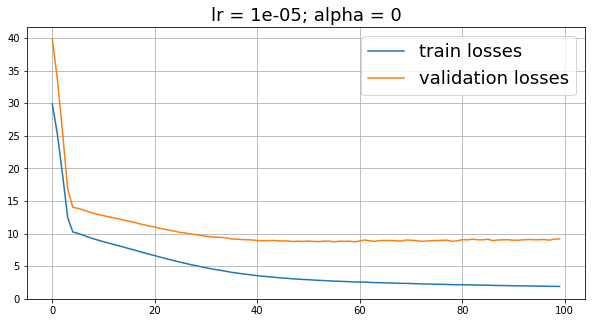

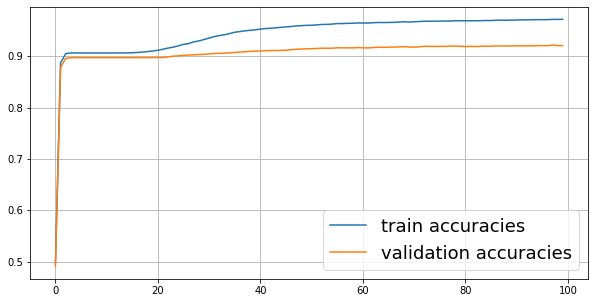

In [21]:
plot_train_progress(LEARNING_RATE, ALPHA, train_losses, val_losses, train_accs, val_accs)